# TERM STRUCTURE COVERAGE USING HULL-WHITE AND EIOPA RISK-FREE CURVE
<a id="0"></a> <br>

The Hull-White model is a very popular choice when modeling interest rates. The risk-free curve is one of the principal inputs into such economic scenario generator. This notebook has 3 sections. The first section uses the EIOPA RFR calibration to produce the yield curve. In the second section, this yield curve is used to produce a number of stochastic scenarios using a HW model. The last section checks how close is the average interest rate from ESG to the term structure provided as input.

### Summary

The goal of this script is to demonstrate a check that verifies if the company is using a sufficienty large number of stochastic scenarios. It also verifies if the term structure used to calibrate the ESG is the same as the one implied in the output.

# Table of Contents  
1. [Note on Smith & Wilson algorithm](#1)
2. [Note on EIOPA RFR curve](#2)
3. [Data requirements](#3)
4. [External dependencies](#4)
5. [Importing data](#5)
6. [Calibration parameters and calibration vector provided by EIOPA](#6)
7. [Smith & Wilson calculation functions](#7)
8. [Hull-White interest rate simulation functions](#8)
9. [Comparison between average ESG output and the assumed term structure](#9)

<a id="1"></a> <br>
## Note on Smith & Wilson algorithm

The calculation of RFR rate was first performed in another script that checks the correct calibration of the EIOPA's RFR output. This example uses a modified Smith&Wilson implementation (The original implementation is availible on [GitHub](https://github.com/qnity):
-  [Python](https://github.com/qnity/insurance_python/tree/main/smith%26wilson)
-  [Matlab](https://github.com/qnity/insurance_matlab/tree/main/smith%26wilson)
-  [JavaScript](https://github.com/qnity/insurance_javascript/tree/main/smith-wilson)



<a id="2"></a> <br>
## Note on EIOPA RFR curve
The recalculation of the RFR curve from EIOPA's parameters is available on:
-  [Jupyter notebook](https://github.com/qnity/insurance_jupyter/tree/main/enough_stochastic_scenarios)

#### Limitations of the implementation
This script covers a synthetic dataset of ESG scenarios.It also simplifies the day-count convention with the assumption that each month represents 1/12-th of a year. The discretisation and numeric integration uses the simplest Euler scheme and the rectangular rule respectively.

<a id="3"></a> <br>
## Data requirements

This script contains the EIOPA risk-free rate publication for March 2023. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en).

The observed maturities `M_Obs` and the calibrated vector `Qb` can be found in the Excel sheet *EIOPA_RFR_20230331_Qb_SW.xlsx*.

For this example, the curve without the volatility adjustment (VA) is used. It can be found in the sheet *SW_Qb_no_VA*. This example is focused on the EUR curve, but this example can be easily modified for any other curve.

The target maturities (`T_Obs`), the additional parameters (`UFR` and `alpha`), and the given curve can be found in the Excel *EIOPA_RFR_20230331_Term_Structures.xlsx*, sheet *RFR_spot_no_VA* if the test looks at the curve without the Volatility Adjustment and the sheet *RFR_spot_with_VA* if the test looks at the curve with the Volatility Adjustment.

Some made up parameters for the Hull-White model are used:

In [1]:
NoOfPaths = 400 # Number of stochastic scenarios
NoOfSteps = 100  # Number of equidistand discrete modelling points ( 50*12 = 600)
T = 50.0         # time horizon in years
lambd = 0.02     # Hull-White parameter lambda
sigma = 0.01     # Hull-White volatility parameter sigma
epsilon = 0.1    # distance epsilon used to calculate for example the instantaneous spot rate

[Back to the top](#0)
<a id="4"></a> <br>
         
## External dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[Back to the top](#0)
<a id="5"></a> <br>
## Importing data

In [3]:
selected_param_file = 'Param_no_VA.csv'
selected_curves_file = 'Curves_no_VA.csv'

In [4]:
param_raw = pd.read_csv(selected_param_file, sep=',',index_col=0)

The country selected is:

In [5]:
country = "Italy"

In [6]:
maturities_country_raw = param_raw.loc[:,country+"_Maturities"].iloc[6:]
param_country_raw = param_raw.loc[:,country + "_Values"].iloc[6:]
extra_param = param_raw.loc[:,country + "_Values"].iloc[:6]

In [7]:
relevant_positions = pd.notna(maturities_country_raw.values)

In [8]:
maturities_country = maturities_country_raw.iloc[relevant_positions]

In [9]:
Qb = param_country_raw.iloc[relevant_positions]

In [10]:
curve_raw = pd.read_csv(selected_curves_file, sep=',',index_col=0)

In [11]:
curve_country = curve_raw.loc[:,country]

[Back to the top](#0)
<a id="6"></a> <br>
## Calibration parameters and calibration vector provided by EIOPA

In [12]:
# Maturity of observations:
M_Obs = np.transpose(np.array(maturities_country.values))

# Ultimate froward rate ufr represents the rate to which the rate curve will converge as time increases:
ufr = extra_param.iloc[3]/100

# Convergence speed parameter alpha controls the speed at which the curve converges towards the ufr from the last liquid point:
alpha = extra_param.iloc[4]

# For which maturities do we want the SW algorithm to calculate the rates. In this case, for every year up to 150:
M_Target = np.transpose(np.arange(1,151)) 

# Qb calibration vector published by EIOPA for the curve calibration:
Qb = np.transpose(np.array(Qb.values))

[Back to the top](#0)
<a id="7"></a> <br>
## Smith & Wilson calculation functions

In this step, the independent version of the Smith&Wilson algorithm is implemented. To do this, two functions are taken from the publicly available repository and modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [13]:
import numpy as np

def sw_extrapolate(m_target, m_obs, Qb, ufr, alpha, eps = 0.00001):
    """Interpolate or extrapolate rates for targeted maturities using a Smith-Wilson algorithm.
       sw_extrapolate(m_target, m_obs, Qb, ufr, alpha) calculates the rates for maturities specified in M_Target using the calibration vector b.
    Args:
        m_target (ndarray): k x 1 array of targeted bond maturities.
        m_obs (ndarray): n x 1 array of observed bond maturities used for calibration.
        Qb (ndarray): n x 1 array of calibration vector calculated on observed bonds.
        ufr (float): Ultimate forward rate.
        alpha (float): Convergence speed parameter.
        eps (float): Initial increment to calculate the instantaneous spot rate

    Returns:
        ndarray: k x 1 array of targeted rates for zero-coupon bonds with maturity from m_target.

    For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf
    """
    def sw_heart(u, v, alpha):
        """Calculate the heart of the Wilson function. SWHeart(u, v, alpha) calculates the matrix H (Heart of the Wilson function) for maturities specified by vectors u and v. The formula is taken from the EIOPA technical specifications paragraph 132.

        Args:
            u (ndarray): n_1 x 1 vector of maturities.
            v (ndarray): n_2 x 1 vector of maturities.
            alpha (float): Convergence speed parameter.

        Returns:
            ndarray: n_1 x n_2 matrix representing the Heart of the Wilson function.
        """
        u_mat = np.tile(u, [v.size, 1]).transpose()
        v_mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_mat + v_mat) + np.exp(-alpha * (u_mat + v_mat)) - alpha * np.absolute(u_mat - v_mat) - np.exp(-alpha * np.absolute(u_mat - v_mat)))

    h = sw_heart(m_target, m_obs, alpha) # Heart of the Wilson function from paragraph 132
    p = np.exp(-np.log(1 + ufr) * m_target) + np.diag(np.exp(-np.log(1 + ufr) * m_target)) @ h @ Qb # Discount pricing function for targeted maturities from paragraph 147

    # If the first element of m_target is zero, replace it with time "epsilon" to avoid division by zero error.
    m_target[0] = eps if m_target[0] == 0 else m_target[0]

    return p ** (-1 / m_target) - 1

[Back to the top](#0)
<a id="8"></a> <br>
## Hull-White interest rate simulation functions

In this step, the functions that calculate the necessary Hull-White outputs are defined. The calculation of a discounted ZCB bond, calculation of a forward rate, the parameter theta and finally the generation of multiple sample paths.

In [14]:
def P0T_f(t, M_Obs, Qb,ufr, alpha):
    """P0T_f function calculates the price of a zero-coupon bond issued at time 0, for a given maturity 't', using the Smith-Wilson extrapolation technique.
         Args:
            t (float or ndarray): Maturities
            m_obs (ndarray): n x 1 array of observed bond maturities used for calibration.
            Qb (ndarray): n x 1 array of calibration vector calculated on observed bonds.
            ufr (float): Ultimate forward rate.
            alpha (float): Convergence speed parameter.
        Returns:
            ndarray: n x 1 the price of zero coupon bonds   
        
        Example of use
            M_Obs = np.array([1,2,3,5,7,10,15,20,30])
            Qb = np.array([0.02474805, 0.02763133, 0.02926931, 0.0302894 , 0.03061605,
               0.03068016, 0.03038397, 0.02999401, 0.02926168])
            ufr = 0.042
            alpha = 0.05        

            # For a single maturity
            t = 5
            price = P0T_f(t, M_Obs, Qb, ufr, alpha)
            print(f"Price of zero-coupon bond with maturity {t} years is: {price}")

            # For multiple maturities
            t = [1, 3, 5, 10]
            prices = P0T_f(t, M_Obs, Qb, ufr, alpha)
            print("Prices of zero-coupon bonds with maturities", t, "years are:")
            print(prices)

    """
    if isinstance(t, np.ndarray): # If the input is a single maturity given as a nuner
        y0T = sw_extrapolate(np.transpose(t),M_Obs, Qb, ufr, alpha)
        out = np.exp(-y0T*np.transpose(t)) 
    else:
        y0T = sw_extrapolate(np.transpose([t]),M_Obs, Qb, ufr, alpha)
        out = np.exp(-y0T*[t]) 
    return out

In [15]:
def f0T(t, P0T, epsilon):
    """
    Calculates the instantaneous forward rate for time t given the zero-coupon bond price function P0T, using the centered finite difference method.

    Args:
        t (float): Time at which the instantaneous forward rate is calculated.
        P0T (function): A function that takes a float argument `t` and returns the price of a zero-coupon bond with maturity `T`.
        epsilon (float): Step size for the centered finite difference method.

    Returns:
        out (float): The instantaneous forward rate at time t, calculated using the centered finite difference method.
    """
    
    p_plus = P0T(t + epsilon)
    p_minus = P0T(t - epsilon)
    return -(np.log(p_plus) - np.log(p_minus)) / (2 * epsilon)

In [16]:
def HW_theta(lambd, sigma, P0T, epsilon):
    """
    Calculates the theta value for the Hull-White model.

    Args:
    - lambd (float): the mean reversion rate
    - sigma (float): the volatility parameter
    - P0T (function): the zero-coupon bond price as a function of time
    - epsilon (float): the parameter used for calculating the derivative of P0T
    - dt (float, optional): the time step size used for numerical differentiation

    Returns:
    - theta (function): the theta function for the Hull-White model
    """
    def theta(t):
        insta_forward_term = 1.0/lambd *(f0T(t+epsilon, P0T, epsilon) - f0T(t-epsilon, P0T, epsilon))/(2.0*epsilon)
        forward_term = f0T(t, P0T, epsilon)
        variance_term = sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
        return insta_forward_term + forward_term + variance_term
    return theta

In [17]:
def Paths(NoOfPaths, NoOfSteps, T, P0T, lambd, sigma, epsilon):
    """
    Simulates a series of stochastic interest rate paths using the Hull-White model.

    Args:
        NoOfPaths (int): The number of paths to simulate.
        NoOfSteps (int): The number of time steps per path.
        T (float): The maturity of the bond.
        P0T (function): A function that returns the bond price at time t=0 for a given maturity T.
        lambd (float): The mean reversion speed.
        sigma (float): The volatility.
        epsilon (float): A small number used for finite difference approximation.

    Returns:
        dict: A dictionary containing arrays with time steps, interest rate paths, and bond prices.
            - time (array): An array of time steps.
            - R (array): An array of interest rate paths with shape (NoOfPaths, NoOfSteps+1).
            - M (array): An array of bond prices with shape (NoOfPaths, NoOfSteps+1).
     
     Original inspiration: https://www.youtube.com/watch?v=BIZdwUDbnDo
    """       
    
    # Initial forward rate at time t->0
    r0 = f0T(epsilon, P0T, epsilon) # r(0) = f(0,0) = - partial derivative of log(P_mkt(0,epsilon) w.r.t epsilon)

    # Calculation of theta 1/lambda * partial derivative of f(0,t) w.r.t. t + f(0,t) + sigma^2/(2lambda^2)* (1=exp(-2*lambda*t))
    theta = HW_theta(lambd, sigma, P0T, epsilon)

    # Generate random noise
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])

    # initialize arrays
    time = np.linspace(0, T, NoOfSteps+1)
    W = np.zeros([NoOfPaths,NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    R[:,0] = r0
    dt = T/float(NoOfSteps)
    
    for i in range(1, NoOfSteps+1):
        # Making sure the samples from the normal distribution have a mean of 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i-1] = (Z[:,i-1] - np.mean(Z[:,i-1])) / np.std(Z[:,i-1])
        R[:,i] = R[:,i-1] + lambd*(theta(time[i-1]) - R[:,i-1]) * dt + sigma * np.power(dt,0.5)* Z[:,i-1] # Euler discretisation scheme of the differential equation
    
    # vectorized numeric integration
    M = np.exp(0.5 * (R[:, :-1] + R[:, 1:]) * dt) 
    M = np.insert(M, 0, 1, axis=1).cumprod(axis=1)
    
    # Outputs
    paths = {"time":time, "R":R, "M":M}
    return paths

[Back to the top](#0)
<a id="9"></a> <br>
## Comparison between average ESG output and the assumed term structure 

In this final section, the ESG output is generated and visualy compared to the assumed term structure.

In [18]:
def mainCalculation(NoOfPaths, NoOfSteps, T, lambd, sigma, P0T, epsilon):
    """
    Calculates and plots the Zero Coupon Bonds (ZCBs) from the Hull-White Model using the analytical formula and the Monte Carlo simulation.
    
    Args:
    - NoOfPaths (int): number of Monte Carlo simulation paths
    - NoOfSteps (int): number of time steps per path
    - T (float): time to maturity
    - lambd (float): mean reversion rate parameter
    - sigma (float): volatility parameter
    - P0T (function): function for the initial discount bond prices
    - epsilon (float): small value to calculate the numerical derivative
    
    Returns:
    - None
    """
 
    paths = Paths(NoOfPaths, NoOfSteps, T, P0T, lambd, sigma, epsilon)
    M = paths["M"]
    t = paths["time"]
    # Compare the price of an option on a ZCB from Monte Carlo and the analytical expression
    P = np.zeros([NoOfSteps+1])
    for i in range(0,NoOfSteps+1):
        P[i] = np.mean(1.0/M[:,i])
    plt.figure(1)
    plt.grid()
    plt.xlabel("T")
    plt.ylabel("P(0,T)")
    plt.plot(t,P0T(t))
    plt.plot(t,P,"--r")
    plt.legend(["P(0,t) market", "P(0,t) Monte Carlo"])
    plt.title("ZCBs from Hull-White Model")

In [20]:
# ZCB obtained from the Market
P0T = lambda t: P0T_f(t, M_Obs, Qb, ufr, alpha)

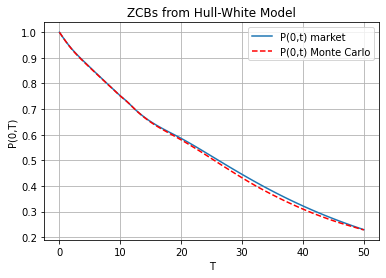

In [21]:
# Final comparison
mainCalculation(NoOfPaths, NoOfSteps, T, lambd, sigma, P0T, epsilon)